In [62]:
import math
import torch
import gpytorch
import botorch
from matplotlib import pyplot as plt
%matplotlib inline

import os
import pandas as pd
from pandas import factorize
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats

In [63]:
class MultiOutputMultiTaskGP(gpytorch.models.ExactGP,botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1
    def __init__(
        self,
        train_X,
        train_Y,
        likelihood,
        data_kernel = 'Matern',
        task_rank = None,
        output_rank = None
    ) -> None:

        num_outputs = train_Y.shape[-1]
        num_tasks = len(torch.unique(train_X[..., -1]))
        #batch_shape, ard_num_dims = train_X.shape[:-2], train_X.shape[-1]
                       
        #self._validate_tensor_args(X=train_X, Y=train_Y)

        super(MultiOutputMultiTaskGP, self).__init__(train_X, train_Y,likelihood)
        self.task_rank = task_rank if task_rank is not None else num_tasks
        self.output_rank = output_rank if output_rank is not None else num_outputs

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_outputs
        )
        
        if data_kernel == 'Matern':
            self.data_kernel = gpytorch.kernels.MaternKernel()
        else:
            self.data_kernel = gpytorch.kernels.RBFKernel()
        self.task_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_tasks, rank = self.task_rank) #default rank is 1
        self.output_kernel = gpytorch.kernels.IndexKernel(num_tasks=num_outputs, rank = self.output_rank) #default rank is 1
        
        self.to(train_X)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        task_term = self.task_kernel(x[..., -1].long())
        data_and_task_x = self.data_kernel(x[..., :-1]).mul(task_term)
        output_x = self.output_kernel.covar_matrix
        covar_x = gpytorch.lazy.KroneckerProductLazyTensor(data_and_task_x, output_x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

In [64]:
def remove_col_outlier(df,col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    keep_inds = ~((df[col] < (Q1 - 2 * IQR)) |(df[col] > (Q3 + 2 * IQR)))
    df = df[keep_inds]
    df.reset_index(inplace = True,drop= True)
    return df,keep_inds

In [65]:
import re
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_excel('data/mk2214.xlsx',sheet_name = 0)
df.columns = [re.sub('[^A-Za-z0-9Δ%]+', '_', element) for element in df.columns]
df.columns  = [re.sub('%','_PCT',element) for element in df.columns]
print(len(df))
df.head()

32


,pH,Conc,Excipient_Conc,Excipient_Type,Y,Viscosity_cP_,Turbidity_AU_,_PCT_Main_Charge,_2_m_particles,_PCT_Monomer
0,5.19,182.56,50,Proline,4.086488,22.1212,0.325814,55.732,8383,95.3
1,6.42,155.18,150,Arginine,0.500904,8.6108,0.334165,54.949,7350,94.5
2,5.18,131.60,200,Proline,3.716095,5.8749,0.232067,54.338,7667,96.0
3,5.77,162.05,200,Proline,0.862782,13.4589,0.305845,54.132,3033,95.2
4,6.31,170.94,200,Arginine,4.812188,11.3663,0.356923,55.271,5550,94.3


In [66]:
cols_feature00 = ['pH','Conc','Excipient_Conc','Excipient_Type']
cols_cate = ['Excipient_Type']
cols_target0 = ['Viscosity_cP_','Turbidity_AU_', 
                '_PCT_Main_Charge', '_2_m_particles', '_PCT_Monomer']
cols_target = ['Viscosity_cP_','_PCT_Main_Charge', '_PCT_Monomer']



In [67]:
df,keep_inds = remove_col_outlier(df,cols_target[0])

In [68]:
ls_model = ['rf','simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'multi-task-multi-output'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax'
cate_transform_option = 'label'
#remove_pred_outlier_option= 0

#output_rank_option = 1 #if 0, no correlation between output
task_rank_option = 3#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'


model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option

if model_option == 'multi-task-single-output' or  model_option =='multi-task-multi-output':
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        task_rank_label = ''
        lik_rank_label = ''



folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label,
                        task_rank_label,lik_rank_label])

figPath = 'output/mk2214-0115-remove-outlier/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)

In [69]:
df_x = df[cols_feature00]
ls_n_levels = [len(df_x[col].unique()) for col in cols_cate]
num_total_cate_levels = np.sum(ls_n_levels)
num_total_cate_levels

2

In [70]:
if cate_transform_option == 'label':
    df_x_label = df_x.copy()
    labels, categories = factorize(df_x[cols_cate[0]])
    df_x_label[cols_cate[0]+"_label"] = labels
    df_x_label = df_x_label.drop(cols_cate[0],axis = 1)
    #df_x_label['task_ind'] = total_df_xy_long['task_ind']
    print(df_x_label)

      pH    Conc  Excipient_Conc  Excipient_Type_label
0   5.19  182.56              50                     0
1   6.42  155.18             150                     1
2   5.18  131.60             200                     0
3   5.77  162.05             200                     0
4   6.31  170.94             200                     1
5   6.45  173.79             200                     0
6   5.77  183.83             150                     0
7   5.77  130.96             150                     0
8   6.40  131.80             200                     0
9   6.45  135.53              50                     1
10  5.24  157.78             150                     0
11  5.82  156.39              50                     1
12  5.32  160.63             150                     1
13  5.45  172.27             200                     1
14  5.71  160.55              50                     0
15  5.30  132.64             200                     1
16  6.41  155.23             150                     0
17  5.29  

In [71]:
df_y = df[cols_target]

In [72]:
df_X_train_wide, df_X_test_wide, df_y_train_wide, df_y_test_wide = train_test_split(df_x_label, df_y, 
                                                                test_size=0.2, random_state=0)
df_X_train_wide.reset_index(inplace = True, drop = True)
df_X_test_wide.reset_index(inplace = True, drop = True)

df_y_train_wide.reset_index(inplace = True, drop = True)
df_y_test_wide.reset_index(inplace = True, drop = True)

In [73]:
def from_wide_to_long(df_X_wide,df_y_wide):
    df_y_1 = pd.DataFrame(df_y_wide[cols_target[0]])
    df_y_2 = pd.DataFrame(df_y_wide[cols_target[1]])
    df_y_3 = pd.DataFrame(df_y_wide[cols_target[2]])
    df_y_1.columns = ['y']
    df_y_2.columns = ['y']
    df_y_3.columns = ['y']

    df_xy_1 = pd.concat((df_X_wide,df_y_1),axis = 1)
    df_xy_2 = pd.concat((df_X_wide,df_y_2),axis = 1)
    df_xy_3 = pd.concat((df_X_wide,df_y_3),axis = 1)
    df_xy_1['task_ind'] = 0
    df_xy_2['task_ind'] = 1
    df_xy_3['task_ind'] = 2
    total_df_xy_long = pd.concat((df_xy_1,df_xy_2,df_xy_3),axis = 0)
    total_df_xy_long.reset_index(inplace = True, drop = True)
   
    total_df_y_long = total_df_xy_long[['y']]
    total_df_x_long = total_df_xy_long[total_df_xy_long.columns.difference(['y'])]
    total_df_x_long=total_df_x_long.reindex(columns=['pH','Conc','Excipient_Conc','Excipient_Type_label','task_ind'])
    
    return total_df_x_long,total_df_y_long

In [74]:
df_X_train,df_y_train = from_wide_to_long(df_X_train_wide,df_y_train_wide)
df_X_test,df_y_test = from_wide_to_long(df_X_test_wide,df_y_test_wide)

In [75]:
# scale features
x_mm_scaler = MinMaxScaler()
scaled_X_train=x_mm_scaler.fit_transform(df_X_train[df_X_train.columns.difference(['task_ind'])])
scaled_X_train = np.concatenate((scaled_X_train,df_X_train['task_ind'].to_numpy().reshape(-1,1)),axis = 1)

scaled_X_test=x_mm_scaler.transform(df_X_test[df_X_train.columns.difference(['task_ind'])])
scaled_X_test = np.concatenate((scaled_X_test,df_X_test['task_ind'].to_numpy().reshape(-1,1)),axis = 1)


#keep the last task indices column untouched !!!

#xct = ColumnTransformer([('x_mm_scaler',MinMaxScaler(),df_X_train.columns.difference(['task_ind']))], 
#                        remainder = 'passthrough')
#scaled_X_train=xct.fit_transform(df_X_train) 
#scaled_X_test=xct.transform(df_X_test)





array([[<Axes: title={'center': '0'}>]], dtype=object)

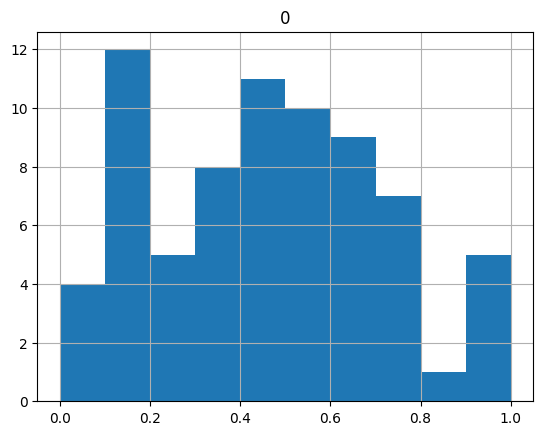

In [76]:

if y_scale_label == 'no-y-scale':
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()
else:
    ls_y_scaler = []
    for task_ind in range(3):
        if y_scale_label == 'y-robust':
            ls_y_scaler.append(RobustScaler())
            #y_scaler = RobustScaler()
    
        elif y_scale_label == 'y-stand':
            #y_scaler = StandardScaler()
            ls_y_scaler.append(StandardScaler())
    
        elif y_scale_label == 'y-minmax':
            #y_scaler = MinMaxScaler()
            ls_y_scaler.append(MinMaxScaler())
    
    
    #ls_scaled_y_train = []
    #ls_scaled_y_test = []
    ls_train_row_inds = []
    ls_test_row_inds = []
    scaled_y_train = df_y_train.copy().to_numpy()
    scaled_y_test = df_y_test.copy().to_numpy()
    for task_ind in range(3):
        y_scaler = ls_y_scaler[task_ind]
        train_row_inds = df_X_train['task_ind']==task_ind
        test_row_inds = df_X_test['task_ind']==task_ind
        ls_train_row_inds.append(train_row_inds)
        ls_test_row_inds.append(test_row_inds)
        tmp_scaled_y_train = y_scaler.fit_transform(df_y_train[train_row_inds])
        tmp_scaled_y_test = y_scaler.transform(df_y_test[test_row_inds])
        scaled_y_train[train_row_inds] = tmp_scaled_y_train
        scaled_y_test[test_row_inds] = tmp_scaled_y_test
        ls_y_scaler[task_ind] = y_scaler
        #ls_scaled_y_train.append(tmp_scaled_y_train)
        #ls_scaled_y_test.append(tmp_scaled_y_test)
        
    #scaled_y_train = np.concatenate(ls_scaled_y_train,axis = 0)
    #scaled_y_test = np.concatenate(ls_scaled_y_test,axis = 0)
    
    
    #scaled_y_train = y_scaler.fit_transform(df_y_train)
    #scaled_y_test = y_scaler.transform(df_y_test)
df_scaled_y_train = pd.DataFrame(scaled_y_train)
df_scaled_y_train.hist()

In [77]:
#if y_scale_option>0:
if y_scale_label != 'no-y-scale':
    t_train_y = torch.Tensor(scaled_y_train)
else:
    t_train_y = torch.Tensor(df_y_train.to_numpy())

#if x_scale_option>0:
if x_scale_label != 'no-x-scale':
    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())

In [78]:
num_outputs = t_train_y.shape[-1]

task_rank = task_rank_option
output_rank = 1
lik_rank = lik_rank_option
if lik_rank is None:
            lik_rank = output_rank

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(
                num_tasks=num_outputs, 
                rank=lik_rank if lik_rank is not None else 0,
            )

model = MultiOutputMultiTaskGP(t_train_x, t_train_y,likelihood,
                               task_rank = task_rank,output_rank = output_rank)

In [79]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 100
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/100 - Loss: 1.542
Iter 2/100 - Loss: 1.415
Iter 3/100 - Loss: 1.298
Iter 4/100 - Loss: 1.194
Iter 5/100 - Loss: 1.103
Iter 6/100 - Loss: 1.018
Iter 7/100 - Loss: 0.938
Iter 8/100 - Loss: 0.861
Iter 9/100 - Loss: 0.790
Iter 10/100 - Loss: 0.725
Iter 11/100 - Loss: 0.666
Iter 12/100 - Loss: 0.607
Iter 13/100 - Loss: 0.547
Iter 14/100 - Loss: 0.488
Iter 15/100 - Loss: 0.434
Iter 16/100 - Loss: 0.386
Iter 17/100 - Loss: 0.340
Iter 18/100 - Loss: 0.295
Iter 19/100 - Loss: 0.255
Iter 20/100 - Loss: 0.220
Iter 21/100 - Loss: 0.190
Iter 22/100 - Loss: 0.161
Iter 23/100 - Loss: 0.136
Iter 24/100 - Loss: 0.114
Iter 25/100 - Loss: 0.094
Iter 26/100 - Loss: 0.075
Iter 27/100 - Loss: 0.057
Iter 28/100 - Loss: 0.041
Iter 29/100 - Loss: 0.026
Iter 30/100 - Loss: 0.009
Iter 31/100 - Loss: -0.006
Iter 32/100 - Loss: -0.019
Iter 33/100 - Loss: -0.027
Iter 34/100 - Loss: -0.033
Iter 35/100 - Loss: -0.036
Iter 36/100 - Loss: -0.038
Iter 37/100 - Loss: -0.038
Iter 38/100 - Loss: -0.037
Iter 39/100 -

In [80]:
if y_scale_label != 'no-y-scale':
    t_test_y = torch.Tensor(scaled_y_test)
else:
    t_test_y = torch.Tensor(df_y_test.to_numpy())

if x_scale_option != 'no-x-scale':
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_test_x = torch.Tensor(df_X_test.to_numpy())


# Set into eval mode
model.eval()
likelihood.eval()

MultitaskGaussianLikelihood(
  (raw_noise_constraint): GreaterThan(1.000E-04)
)

In [81]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_pred = likelihood(model(t_test_x))   
        test_mean = test_pred.mean
        test_lower, test_upper = test_pred.confidence_region()
        train_pred = likelihood(model(t_train_x))
        train_mean = train_pred.mean
        train_lower, train_upper = train_pred.confidence_region()

        #t_std_train = train_mean - train_lower
        #t_std_test = test_mean - test_lower

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [82]:
if y_scale_option=='no-y-scale':
    arr_train_x = t_train_x.detach().numpy()
    arr_train_y = t_train_y.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()
    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = test_mean.detach().numpy()
    arr_test_lower = test_lower.detach().numpy()
    arr_test_upper = test_upper.detach().numpy()

    arr_train_mean = train_mean.detach().numpy()
    arr_train_lower = train_lower.detach().numpy()
    arr_train_upper = train_upper.detach().numpy()
else:
    arr_train_x = t_train_x.detach().numpy()
    arr_test_x = t_test_x.detach().numpy()

    arr_train_y = t_train_y.detach().numpy()
    arr_train_mean = arr_train_y.copy()
    arr_train_lower = arr_train_y.copy()
    arr_train_upper = arr_train_y.copy()

    arr_test_y = t_test_y.detach().numpy()
    arr_test_mean = arr_test_y.copy()
    arr_test_lower = arr_test_y.copy()
    arr_test_upper = arr_test_y.copy()

    for task_ind in range(3):
        y_scaler = ls_y_scaler[task_ind]
        converted_train_ind = df_y_train.index[ls_train_row_inds[task_ind]].tolist()
        converted_test_ind = df_y_test.index[ls_test_row_inds[task_ind]].tolist()
        arr_train_y[ls_train_row_inds[task_ind]] = y_scaler.inverse_transform(t_train_y[converted_train_ind])
        arr_train_mean[ls_train_row_inds[task_ind]] = y_scaler.inverse_transform(train_mean[converted_train_ind])
        arr_train_lower[ls_train_row_inds[task_ind]] = y_scaler.inverse_transform(train_lower[converted_train_ind])
        arr_train_upper[ls_train_row_inds[task_ind]] = y_scaler.inverse_transform(train_upper[converted_train_ind])

        arr_test_y[ls_test_row_inds[task_ind]] = y_scaler.inverse_transform(t_test_y[converted_test_ind])
        arr_test_mean[ls_test_row_inds[task_ind]] = y_scaler.inverse_transform(test_mean[converted_test_ind])
        arr_test_lower[ls_test_row_inds[task_ind]] = y_scaler.inverse_transform(test_lower[converted_test_ind])
        arr_test_upper[ls_test_row_inds[task_ind]] = y_scaler.inverse_transform(test_upper[converted_test_ind])

        """
        arr_train_y = y_scaler.inverse_transform(t_train_y)
        arr_train_mean = y_scaler.inverse_transform(train_mean)
        arr_train_lower = y_scaler.inverse_transform(train_lower)
        arr_train_upper = y_scaler.inverse_transform(train_upper)

        arr_test_y = t_test_y.detach().numpy()
        arr_test_mean = y_scaler.inverse_transform(test_mean)
        arr_test_lower = y_scaler.inverse_transform(test_lower)
        arr_test_upper = y_scaler.inverse_transform(test_upper)
        """

/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_44971/3458591713.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_44971/3458591713.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_44971/3458591713.py:59: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k*" (-> color='k'). The keyword argument will take precedence.
  y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)
/

         Task_1_Output_1  Task_2_Output_1  Task_3_Output_1
MAE                 3.06             0.47             0.27
MAE2                2.50             0.45             0.24
MSE                15.57             0.38             0.08
RMSE               15.57             0.38             0.08
MAPE                0.33             0.01             0.00
MAXE                7.33             1.04             0.44
EVS                 0.11             0.03             0.54
R2                 -0.71            -0.36             0.49
AVG_STD            12.46             1.35             0.88
MIN_STD            11.47             1.33             0.82
MAX_STD            13.88             1.40             0.95
         Task_1_Output_1  Task_2_Output_1  Task_3_Output_1
MAE                 2.41             0.59             0.29
MAE2                2.19             0.51             0.26
MSE                10.44             0.53             0.12
RMSE               10.44             0.53             0.

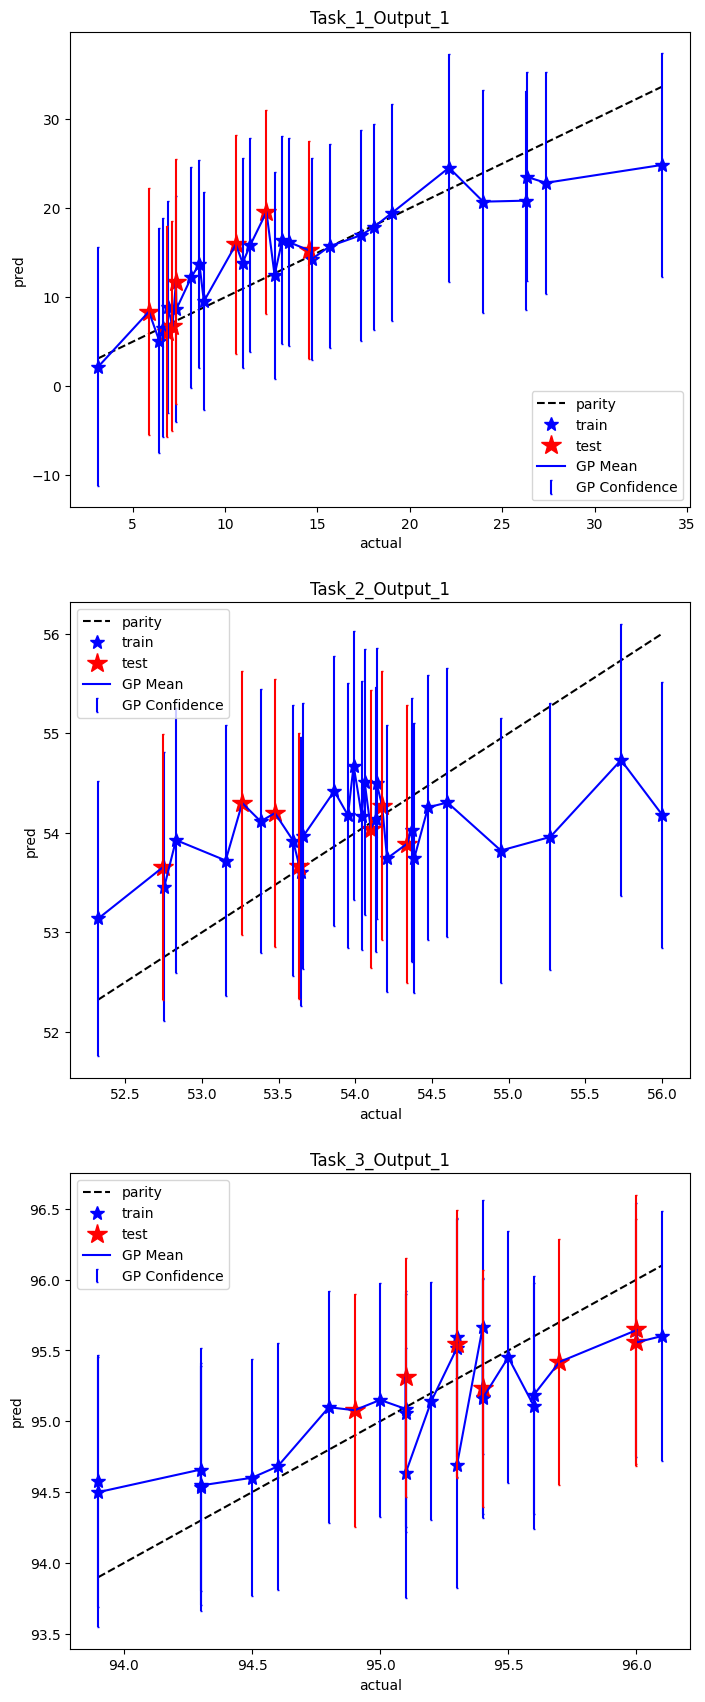

In [83]:
from sklearn.metrics import mean_squared_error

uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False
cols_target_wide = []

plot_axis_lb = df_y.min(axis = 0) - 0.4 * df_y.std(axis = 0)
plot_axis_ub = df_y.max(axis = 0) + 0.4 * df_y.std(axis = 0)

#num_outputs = arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))
num_outputs = 1
num_tasks = len(cols_target)

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
  for j in range(num_outputs):
    a = j + num_outputs*task_ind
    tmp_col_y = 'Task_'+str(task_ind+1) + '_Output_'+str(j+1)
    cols_target_wide.append(tmp_col_y)
    r_train_y = arr_train_y[arr_train_x[:,-1]==task_ind,j]
    r_train_mean_y =arr_train_mean[arr_train_x[:,-1]==task_ind,j]
    r_train_lower_y =arr_train_lower[arr_train_x[:,-1]==task_ind,j]
    r_train_upper_y =arr_train_upper[arr_train_x[:,-1]==task_ind,j]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[arr_test_x[:,-1]==task_ind,j]
    r_test_mean_y =arr_test_mean[arr_test_x[:,-1]==task_ind,j]
    r_test_lower_y =arr_test_lower[arr_test_x[:,-1]==task_ind,j]
    r_test_upper_y =arr_test_upper[arr_test_x[:,-1]==task_ind,j]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as blue stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'k*',c = 'blue',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'k*',c = 'red',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])

    y_axes[a].legend(['parity','train','test','GP Mean','GP Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']


if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target_wide, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD','MIN_STD','MAX_STD'])
print(df_train_metrics)


df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

In [87]:
from botorch.acquisition.objective import LinearMCObjective
from botorch.acquisition import qNoisyExpectedImprovement
from botorch.acquisition import LogExpectedImprovement
#from botorch.models.multitask import MultiTaskGP
from botorch.optim import optimize_acqf

In [91]:
bestf_sofar = mll(output, t_train_y).detach()
bestf_sofar

tensor(-2100.5771)

In [92]:
n_input = t_train_x.shape[1] - 1
bounds = torch.stack([torch.zeros(n_input), torch.ones(n_input)])#This will be used for the acquisition function

#qNEI = qNoisyExpectedImprovement(model=model,X_baseline = t_train_x)
logEI = LogExpectedImprovement(model=model,best_f = bestf_sofar)
candidate, acq_value = optimize_acqf(
    logEI, bounds=bounds, q=5, num_restarts=5, raw_samples=2000,
  )

AssertionError: Expected X to be `batch_shape x q=1 x d`, but got X with shape torch.Size([2000, 5, 4]).

In [ ]:
BestSoFar=[]
Bayesian_iterations=10
for t in range(Bayesian_iterations):
 # Use acquisition function to find the optimum
   #mt_obj = LinearMCObjective(weights=torch.tensor([1]))
   #qNEI = qNoisyExpectedImprovement(model=model, X_baseline=train_X, objective=mt_obj)
   qNEI = qNoisyExpectedImprovement(model=model)
   candidate, acq_value = optimize_acqf(
    qNEI, bounds=bounds, q=5, num_restarts=5, raw_samples=2000,
  )

   new_y=f_target(candidate[0:2])

   ind=np.argmax(new_y)
   BestCandidate=candidate[ind]
   BestNew_y=new_y[ind]

   train_X = torch.cat([train_X,BestCandidate.reshape([1,train_X.shape[1]]),])
   train_Y = torch.cat([train_Y, BestNew_y.reshape([1,train_Y.shape[1]]),])

   model = MultiTaskGP(train_X, train_Y, task_feature=-2)
   model.train()
   likelihood.train()
   mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
   optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

   for i in range(training_iterations):
     optimizer.zero_grad()
     output = model(train_X)
     loss = -mll(output, train_Y[:,0])
     loss.backward()
     print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
     optimizer.step()
   BestSoFar.append(train_Y.max())